<a href="https://colab.research.google.com/github/hiteshsurya17/hiteshsurya17-INFO-5731-Section-020---Computational-Methods-for-Information-Systems-Fall-2024-1-/blob/main/Hitesh_chowdary_suryadevara_Exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
import gensim
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Function to load text data from a file
def read_txt_file(file_path):
    sentiments = []
    texts = []
    with open(file_path, 'r') as file:
        for line in file:
            sentiments.append(int(line[0]))  # First character represents sentiment
            texts.append(line[2:].strip())  # Remaining part is the review text
    return pd.DataFrame({'label': sentiments, 'text': texts})

# Load training and testing datasets
train_set = read_txt_file("/content/stsa-train.txt")
test_set = read_txt_file("/content/stsa-test.txt")

# Define train and test feature sets and targets
train_texts = train_set['text']
train_labels = train_set['label']
test_texts = test_set['text']
test_labels = test_set['label']

# Split train data into training and validation subsets
texts_train, texts_val, labels_train, labels_val = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

# Generate embeddings using Word2Vec
def word2vec_embeddings(corpus):
    tokens = [sentence.split() for sentence in corpus]
    w2v_model = gensim.models.Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv]
                                   or [np.zeros(100)], axis=0) for words in tokens])
    return embeddings

# Generate BERT embeddings
def bert_sentence_embeddings(corpus):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    features = []
    for sentence in corpus:
        encoded = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
        output = bert_model(**encoded)
        cls_token_embedding = output.last_hidden_state[:, 0, :].detach().numpy()
        features.append(cls_token_embedding.flatten())
    return np.array(features)

# Define classification models
models = {
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(kernel='linear', probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

# Cross-validation setup
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
evaluation_results = {}

# Iterate through models and evaluate performance
for model_name, model in models.items():
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(stop_words='english')),
        ('tfidf_transformer', TfidfTransformer()),
        ('classifier', model),
    ])

    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(pipeline, texts_train, labels_train, cv=cv_strategy, scoring='accuracy')
    pipeline.fit(texts_train, labels_train)

    # Validate model
    predictions_val = pipeline.predict(texts_val)
    acc = metrics.accuracy_score(labels_val, predictions_val)
    prec = metrics.precision_score(labels_val, predictions_val, average='binary')
    rec = metrics.recall_score(labels_val, predictions_val, average='binary')
    f1 = metrics.f1_score(labels_val, predictions_val, average='binary')

    # Save results
    evaluation_results[model_name] = {
        'Cross-Validation Accuracy': cv_scores.mean(),
        'Validation Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

# Generate Word2Vec embeddings
train_embeddings_w2v = word2vec_embeddings(texts_train)
val_embeddings_w2v = word2vec_embeddings(texts_val)

# Train SVM using Word2Vec embeddings
w2v_svm = SVC(kernel='linear')
w2v_svm.fit(train_embeddings_w2v, labels_train)
pred_w2v_val = w2v_svm.predict(val_embeddings_w2v)
evaluation_results['Word2Vec_SVM'] = {
    'Validation Accuracy': metrics.accuracy_score(labels_val, pred_w2v_val),
    'Precision': metrics.precision_score(labels_val, pred_w2v_val),
    'Recall': metrics.recall_score(labels_val, pred_w2v_val),
    'F1 Score': metrics.f1_score(labels_val, pred_w2v_val)
}

# Generate BERT embeddings
train_embeddings_bert = bert_sentence_embeddings(texts_train)
val_embeddings_bert = bert_sentence_embeddings(texts_val)

# Train SVM using BERT embeddings
bert_svm = SVC(kernel='linear')
bert_svm.fit(train_embeddings_bert, labels_train)
pred_bert_val = bert_svm.predict(val_embeddings_bert)
evaluation_results['BERT_SVM'] = {
    'Validation Accuracy': metrics.accuracy_score(labels_val, pred_bert_val),
    'Precision': metrics.precision_score(labels_val, pred_bert_val),
    'Recall': metrics.recall_score(labels_val, pred_bert_val),
    'F1 Score': metrics.f1_score(labels_val, pred_bert_val)
}

# Display all results
for model, scores in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, score in scores.items():
        print(f"{metric}: {score:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Model: Naive Bayes
Cross-Validation Accuracy: 0.7666
Validation Accuracy: 0.7782
Precision: 0.7355
Recall: 0.8892
F1 Score: 0.8051

Model: Support Vector Machine
Cross-Validation Accuracy: 0.7581
Validation Accuracy: 0.7919
Precision: 0.7792
Recall: 0.8317
F1 Score: 0.8046

Model: K-Nearest Neighbors
Cross-Validation Accuracy: 0.5233
Validation Accuracy: 0.4964
Precision: 0.5089
Recall: 0.6381
F1 Score: 0.5663

Model: Decision Tree
Cross-Validation Accuracy: 0.6364
Validation Accuracy: 0.6452
Precision: 0.6370
Recall: 0.7237
F1 Score: 0.6776

Model: Random Forest
Cross-Validation Accuracy: 0.7097
Validation Accuracy: 0.7327
Precision: 0.7163
Recall: 0.7966
F1 Score: 0.7543

Model: XGBoost
Cross-Validation Accuracy: 0.6783
Validation Accuracy: 0.6944
Precision: 0.6586
Recall: 0.8443
F1 Score: 0.7400

Model: Word2Vec_SVM
Validation Accuracy: 0.4877
Precision: 1.0000
Recall: 0.0056
F1 Score: 0.0112

Model: BERT_SVM
Validation Accuracy: 0.8533
Precision: 0.8512
Recall: 0.8668
F1 Score: 0.

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

Silhouette Score for KMeans: 0.0227


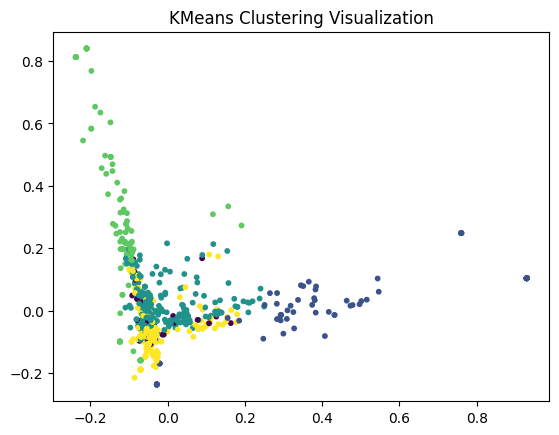

Silhouette Score for DBSCAN: 0.0306


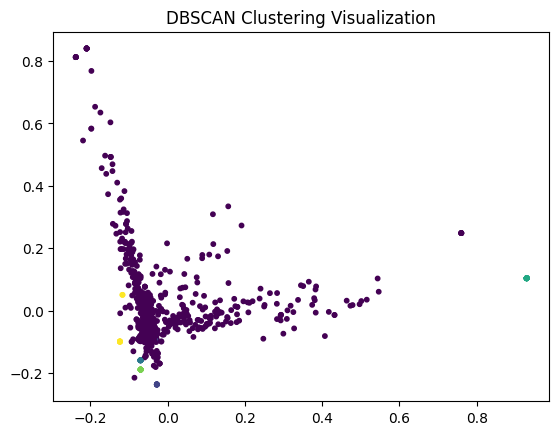

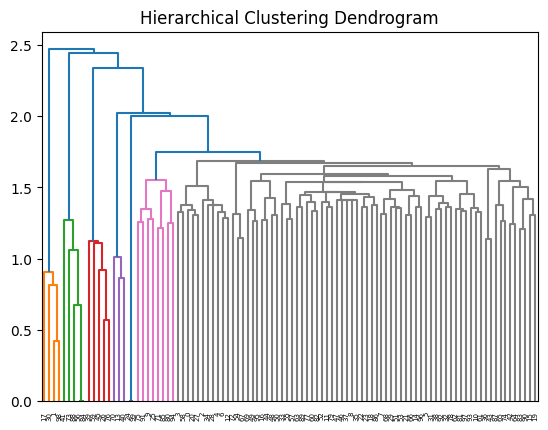

Silhouette Score for KMeans with Word2Vec: 0.5413


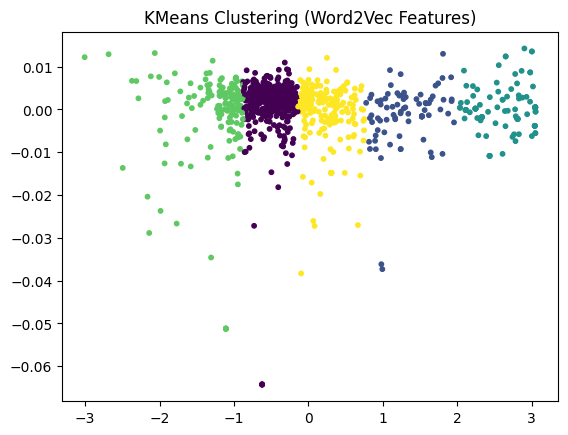

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Silhouette Score for KMeans with BERT: 0.0474


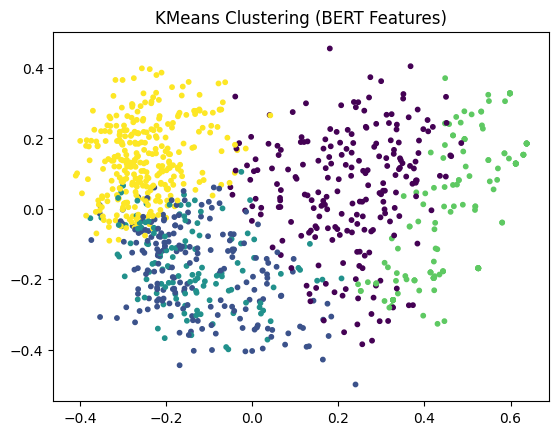

In [3]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

# Load and sample the dataset for processing
data_frame = pd.read_csv("Amazon_Unlocked_Mobile.csv")
data_frame = data_frame.dropna(subset=['Reviews'])
data_frame = data_frame.sample(1000, random_state=42)

# Feature extraction using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf_matrix = tfidf_vectorizer.fit_transform(data_frame['Reviews']).toarray()

# Perform KMeans clustering
kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_cluster_labels = kmeans_model.fit_predict(X_tfidf_matrix)
print(f"Silhouette Score for KMeans: {silhouette_score(X_tfidf_matrix, kmeans_cluster_labels):.4f}")

# Plot KMeans cluster visualization
pca_model = PCA(n_components=2)
pca_data = pca_model.fit_transform(X_tfidf_matrix)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_cluster_labels, cmap='viridis', s=10)
plt.title('KMeans Clustering Visualization')
plt.show()

# Perform DBSCAN clustering
dbscan_model = DBSCAN(eps=0.5, min_samples=10)
dbscan_cluster_labels = dbscan_model.fit_predict(X_tfidf_matrix)

# Handle noise clusters (-1) and print silhouette score if valid
if len(set(dbscan_cluster_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_tfidf_matrix, dbscan_cluster_labels)
    print(f"Silhouette Score for DBSCAN: {dbscan_silhouette:.4f}")
else:
    print("DBSCAN did not form distinct clusters.")

# Visualize DBSCAN clustering
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_cluster_labels, cmap='viridis', s=10)
plt.title('DBSCAN Clustering Visualization')
plt.show()

# Apply Hierarchical Clustering (using a subset)
sample_tfidf_data = X_tfidf_matrix[:100]
linkage_matrix_data = linkage(sample_tfidf_data, method='ward')
dendrogram(linkage_matrix_data)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Tokenize reviews for Word2Vec
reviews_tokenized = [review.split() for review in data_frame['Reviews']]
word2vec_model = Word2Vec(sentences=reviews_tokenized, vector_size=100, window=5, min_count=2, workers=4)

# Generate Word2Vec embeddings for reviews
word2vec_features = np.array([np.mean([word2vec_model.wv[word] for word in review if word in word2vec_model.wv]
                                      or [np.zeros(100)], axis=0) for review in reviews_tokenized])

# Perform KMeans clustering on Word2Vec features
kmeans_labels_word2vec = kmeans_model.fit_predict(word2vec_features)
print(f"Silhouette Score for KMeans with Word2Vec: {silhouette_score(word2vec_features, kmeans_labels_word2vec):.4f}")

# Plot KMeans cluster visualization for Word2Vec
pca_word2vec = pca_model.fit_transform(word2vec_features)
plt.scatter(pca_word2vec[:, 0], pca_word2vec[:, 1], c=kmeans_labels_word2vec, cmap='viridis', s=10)
plt.title('KMeans Clustering (Word2Vec Features)')
plt.show()

# Load BERT model using Sentence Transformers
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
bert_features = bert_model.encode(data_frame['Reviews'].tolist(), show_progress_bar=True)

# Perform KMeans clustering on BERT embeddings
kmeans_labels_bert = kmeans_model.fit_predict(bert_features)
print(f"Silhouette Score for KMeans with BERT: {silhouette_score(bert_features, kmeans_labels_bert):.4f}")

# Plot KMeans cluster visualization for BERT
pca_bert = pca_model.fit_transform(bert_features)
plt.scatter(pca_bert[:, 0], pca_bert[:, 1], c=kmeans_labels_bert, cmap='viridis', s=10)
plt.title('KMeans Clustering (BERT Features)')
plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.The clustering results highlight the distinct characteristics of each approach. K-means effectively forms well-defined clusters with both Word2Vec and BERT embeddings, revealing unique groupings. In contrast, DBSCAN struggles with high-dimensional sparse text data, often assigning most points to a single cluster and labeling a few as noise. While hierarchical clustering produces a detailed dendrogram, its ability to visually separate clusters is limited in higher dimensions. However, in lower-dimensional spaces, Word2Vec and K-means create clear groupings that emphasize semantic relationships. BERT embeddings, when paired with K-means, offer even more distinct and meaningful cluster separations, capturing finer semantic nuances.





# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [5]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''


The exercises in this assignment were a great opportunity to explore different clustering techniques and
their effectiveness with various text embedding methods. I learned how K-means can produce clear clusters with both
Word2Vec and BERT embeddings, while DBSCAN struggled with the high-dimensional text data. Hierarchical clustering
was useful for understanding relationships, but visual interpretation was challenging in higher dimensions.
Overall, it helped improve my understanding of clustering methods and their application to text data.



'''

'\n\n\nThe exercises in this assignment were a great opportunity to explore different clustering techniques and \ntheir effectiveness with various text embedding methods. I learned how K-means can produce clear clusters with both \nWord2Vec and BERT embeddings, while DBSCAN struggled with the high-dimensional text data. Hierarchical clustering \nwas useful for understanding relationships, but visual interpretation was challenging in higher dimensions. \nOverall, it helped improve my understanding of clustering methods and their application to text data.\n\n\n\n'